In [0]:
access_key = "cEHFD5KQSB2yfcAAGPnyNt+hBFoniH5UCgquqZKmh1yypAwCe26MlKtTpLHX7dW2apc3Uh12571B+AStcnMAfg=="
endpoints = "https://adlsteam3.dfs.core.windows.net/"

In [0]:
spark.conf.set("fs.azure.account.key.adlsteam3.dfs.core.windows.net", access_key)

In [0]:
inventory_spark_df = spark.read.csv("abfss://bronze@adlsteam3.dfs.core.windows.net/inventory (1).csv", header=True, inferSchema=True)
inventory_spark_df.show(5)

+------------+----------+-----------+-----------------+-----------------+----------------+
|warehouse_id|product_id|stock_level|reorder_threshold|last_restock_date|next_restock_due|
+------------+----------+-----------+-----------------+-----------------+----------------+
|        W001|     P0061|        955|              190|       2025-07-31|      2025-08-14|
|        W007|     P0055|        408|              125|       2025-07-28|      2025-08-12|
|        W005|     P0077|        318|              144|       2025-07-18|      2025-08-12|
|        W007|     P0087|        896|              182|       2025-09-07|      2025-10-02|
|        W003|     P0088|        786|              151|       2025-08-05|      2025-08-20|
+------------+----------+-----------+-----------------+-----------------+----------------+
only showing top 5 rows


In [0]:
inventory_df = inventory_spark_df.toPandas()

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

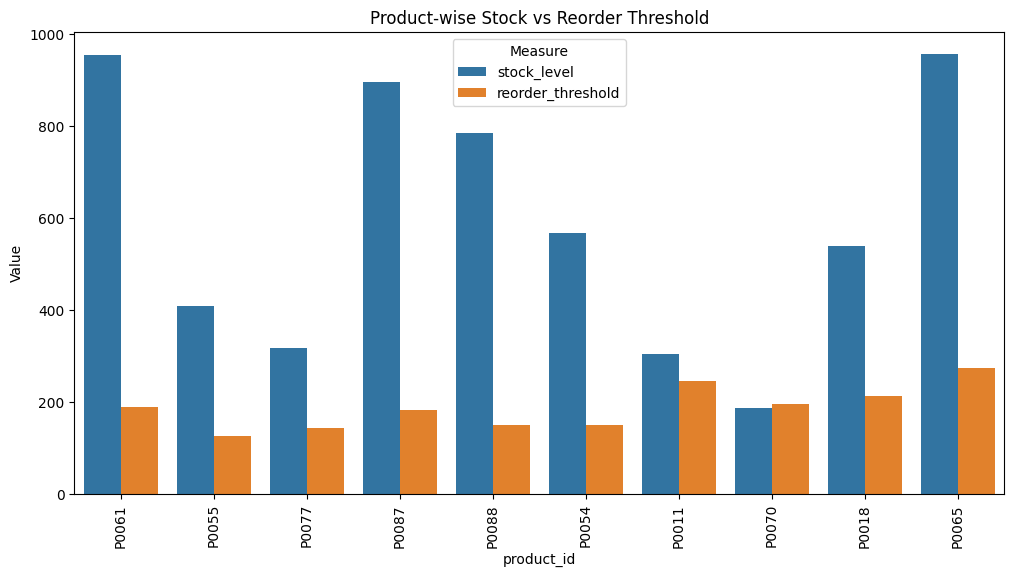

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
 
# Take first 10 rows
sample_df = inventory_df.head(10)
 
plt.figure(figsize=(12,6))
 
# Reshape data so we can compare stock vs threshold in bars
melted_df = sample_df.melt(
    id_vars=['product_id','warehouse_id'],
    value_vars=['stock_level','reorder_threshold'],
    var_name='Measure',
    value_name='Value'
)
 
# Bar plot: shows stock vs reorder threshold for each product
sns.barplot(
    data=melted_df,
    x='product_id',
    y='Value',
    hue='Measure'
)
 
plt.xticks(rotation=90)
plt.ylabel("Value")
plt.title("Product-wise Stock vs Reorder Threshold")
plt.legend(title="Measure")
plt.show()




 

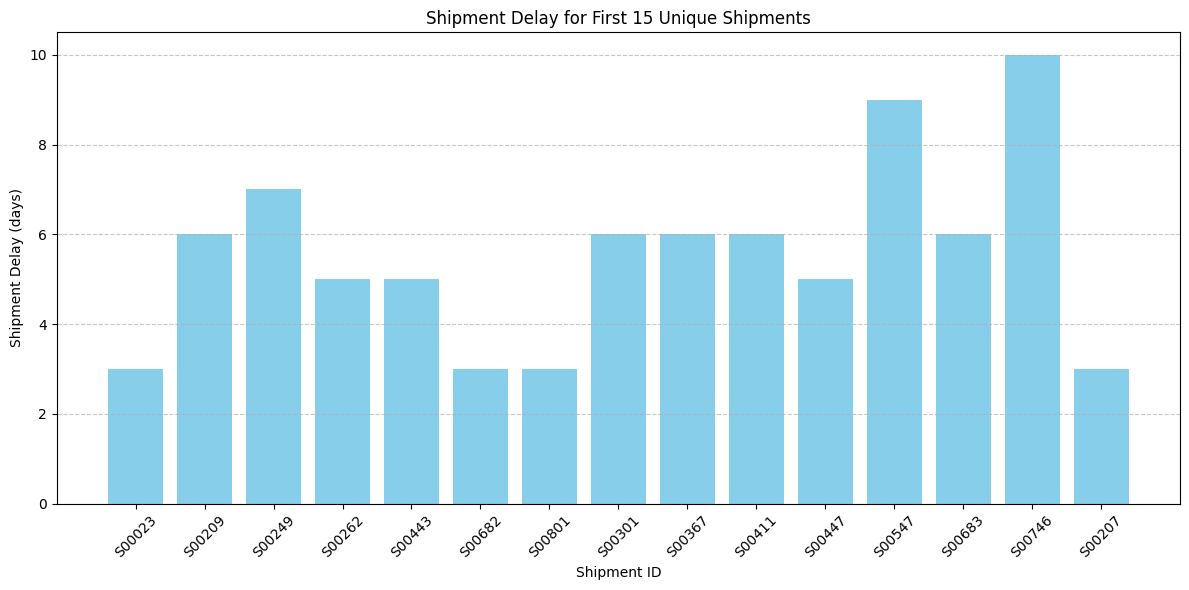

In [0]:
from pyspark.sql.functions import col, to_date, datediff
import matplotlib.pyplot as plt
 
# Load data
df = spark.read.csv("abfss://bronze@adlsteam3.dfs.core.windows.net/shipments.csv", header=True, inferSchema=True)
 
# Parse dates and compute delay
df = df.withColumn("ship_date", to_date(col("ship_date"))) \
       .withColumn("delivery_date", to_date(col("delivery_date"))) \
       .withColumn("shipment_delay", datediff(col("delivery_date"), col("ship_date")))
 
# Select first 15 unique shipment_ids
first_15_shipments = df.select("shipment_id", "shipment_delay").dropDuplicates(["shipment_id"]).limit(15)
 
# Convert to Pandas for plotting
first_15_pd = first_15_shipments.toPandas()
 
# Plot bar chart
plt.figure(figsize=(12,6))
plt.bar(first_15_pd['shipment_id'].astype(str), first_15_pd['shipment_delay'], color='skyblue')
plt.xlabel("Shipment ID")
plt.ylabel("Shipment Delay (days)")
plt.title("Shipment Delay for First 15 Unique Shipments")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
 

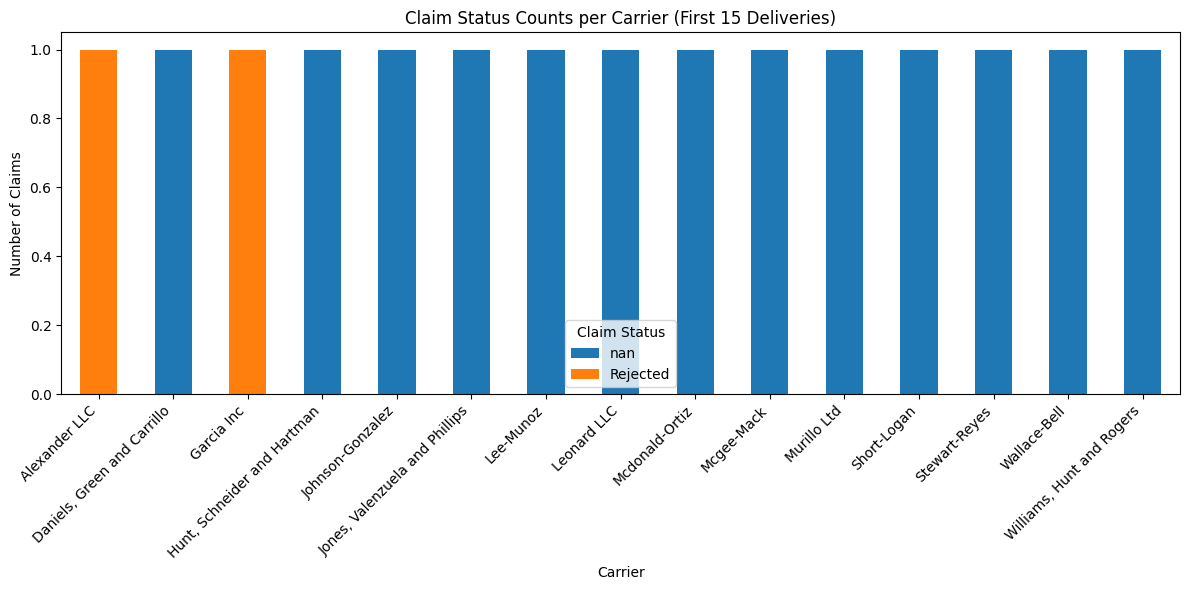

In [0]:
# Import necessary libraries

from pyspark.sql import SparkSession

from pyspark.sql.functions import col

import pandas as pd

import matplotlib.pyplot as plt
 
# Assume your tables are already loaded as Spark DataFrames

# delivery_logs: delivery_id, shipment_id, carrier, status, delivery_duration_days, damage_flag, proof_of_delivery_status

# claims: claim_id, delivery_id, reason, amount_claimed, claim_status, claim_date, resolved_date
 
# Step 1: Take first 15 deliveries
delivery_logs_df = spark.read.csv("abfss://bronze@adlsteam3.dfs.core.windows.net/delivery_logs.csv", header=True, inferSchema=True)

first_15_deliveries = delivery_logs_df.select("delivery_id", "carrier").limit(15)
 
# Step 2: Join with claims table
claims_df = spark.read.csv("abfss://bronze@adlsteam3.dfs.core.windows.net/claims.csv", header=True, inferSchema=True)

claims_for_15 = first_15_deliveries.join(claims_df, "delivery_id", "left")
 
# Step 3: Group by carrier and claim_status, count the number of claims

claim_df_counts = claims_for_15.groupBy("carrier", "claim_status").count()
 
# Step 4: Convert to Pandas for plotting

claim_df_counts_pd = claim_df_counts.toPandas()
 
# Step 5: Pivot to get claim_status as columns for stacked bar plot

claim_counts_pivot = claim_df_counts_pd.pivot(index='carrier', columns='claim_status', values='count').fillna(0)
 
# Step 6: Plot stacked bar plot

claim_counts_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
 
plt.xlabel("Carrier")

plt.ylabel("Number of Claims")

plt.title("Claim Status Counts per Carrier (First 15 Deliveries)")

plt.xticks(rotation=45, ha='right')

plt.legend(title="Claim Status")

plt.tight_layout()

plt.show()

 